<a href="https://colab.research.google.com/github/satani99/qa_system/blob/main/RoBERTa_SQuAD_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 32.6 MB/s 
     |████████████████████████████████| 132 kB 77.5 MB/s 
     |████████████████████████████████| 212 kB 80.3 MB/s 
     |████████████████████████████████| 182 kB 77.1 MB/s 
     |████████████████████████████████| 127 kB 81.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
from datasets import get_dataset_config_names 

domains = get_dataset_config_names('adversarial_qa')
domains

['adversarialQA', 'dbidaf', 'dbert', 'droberta']

In [3]:
from datasets import load_dataset

adv_qa = load_dataset("adversarial_qa", name="droberta")

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Dataset adversarial_qa downloaded and prepared to /root/.cache/huggingface/datasets/adversarial_qa/droberta/1.0.0/92356be07b087c5c6a543138757828b8d61ca34de8a87807d40bbc0e6c68f04b. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
print(adv_qa["train"]['answers'][1])

{'text': ["his Légion d'honneur star"], 'answer_start': [458]}


In [5]:
import pandas as pd 

dfs = {split: dset.to_pandas() for split, dset in adv_qa.flatten().items()} 

for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 10000
Number of questions in validation: 1000
Number of questions in test: 1000


In [6]:
qa_cols = ['title', 'question', 'answers.text', 
           'answers.answer_start', 'context']
sample_df = dfs["train"][qa_cols].sample(2, random_state=42)
sample_df

,title,question,answers.text,answers.answer_start,context
6252,Aspirated_consonant,What besides English can have the aspiration?,[In some languages],[0],"In some languages, such as English, aspiration..."
4684,Party_leaders_of_the_United_States_House_of_Re...,what is the job of a floor leader?,[devising and implementing his party's strateg...,[344],"A party's floor leader, in conjunction with ot..."


In [7]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'In some languages'

In [8]:
import matplotlib.pyplot as plt

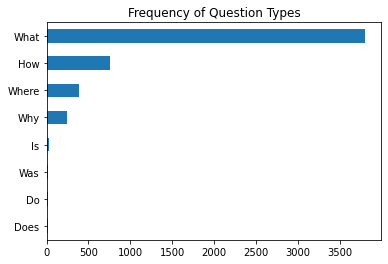

In [9]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [10]:
for question_type in ["What", "How", "Where"]:
  for question in (
      dfs["train"][dfs["train"].question.str.startswith(question_type)]
      .sample(n=3, random_state=42)['question']):
    print(question)

What is unique about this language?
What is the third type of dog tail shape mentioned?
What phrase shows the author's bias against heresy?
How have classrooms changed since the 70s?
How is YouTube Red different from the regular streaming service?
How does Carcavallo characterize his demonstrations?
Where could you find someone who had 4 professions?
Where do Korean Presbyterians not have their own independent churches?
Where is Iran?


In [12]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 31.2 MB/s 
     |████████████████████████████████| 7.6 MB 58.8 MB/s 


In [17]:
from transformers import AutoTokenizer 

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/107 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/477 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [18]:
question = "What was a possible consequence of belief in evolution?"
context = "Father Joseph Carrier, C.S.C. was Director of the Science Museum and the Library and Professor of Chemistry and Physics until 1874. Carrier taught that scientific research and its promise for progress were not antagonistic to the ideals of intellectual and moral culture endorsed by the Church. One of Carrier's students was Father John Augustine Zahm (1851–1921) who was made Professor and Co-Director of the Science Department at age 23 and by 1900 was a nationally prominent scientist and naturalist. Zahm was active in the Catholic Summer School movement, which introduced Catholic laity to contemporary intellectual issues. His book Evolution and Dogma (1896) defended certain aspects of evolutionary theory as true, and argued, moreover, that even the great Church teachers Thomas Aquinas and Augustine taught something like it. The intervention of Irish American Catholics in Rome prevented Zahm's censure by the Vatican. In 1913, Zahm and former President Theodore Roosevelt embarked on a major expedition through the Amazon."
inputs = tokenizer(question, context, return_tensors="pt")

In [19]:
inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [20]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] what was a possible consequence of belief in evolution? [SEP] father joseph carrier, c. s. c. was director of the science museum and the library and professor of chemistry and physics until 1874. carrier taught that scientific research and its promise for progress were not antagonistic to the ideals of intellectual and moral culture endorsed by the church. one of carrier's students was father john augustine zahm ( 1851 – 1921 ) who was made professor and co - director of the science department at age 23 and by 1900 was a nationally prominent scientist and naturalist. zahm was active in the catholic summer school movement, which introduced catholic laity to contemporary intellectual issues. his book evolution and dogma ( 1896 ) defended certain aspects of evolutionary theory as true, and argued, moreover, that even the great church teachers thomas aquinas and augustine taught something like it. the intervention of irish american catholics in rome prevented zahm's censure by the va

In [22]:
import torch
from transformers import AutoModelForQuestionAnswering 

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt) 

with torch.no_grad():
  outputs = model(**inputs)

print(outputs)

Downloading:   0%|          | 0.00/133M [00:00<?, ?B/s]

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[ 2.8269, -5.9491, -6.1166, -5.8534, -5.9515, -6.1575, -6.1171, -6.1363,
         -6.2266, -6.3165, -6.8443,  2.8269, -5.6184, -6.1837, -6.3807, -6.7098,
         -6.2861, -6.7967, -6.6775, -6.8746, -6.7638, -6.9525, -6.3929, -6.1162,
         -6.4431, -6.2800, -5.8543, -6.6169, -6.6536, -6.2168, -6.5348, -6.6162,
         -6.0884, -6.4546, -6.1951, -6.6760, -6.5372, -6.2803, -6.2885, -6.7806,
         -5.6112, -6.0663, -5.7036, -2.4795, -3.6890, -6.3358, -3.3576, -1.9117,
         -4.7447, -0.4180, -5.3424, -3.1503, -2.6164, -6.1222, -5.8654, -4.8069,
         -3.9098, -6.2211, -3.0243, -6.3093, -2.4806, -5.2327, -5.3690, -5.9723,
         -4.2439, -4.6292, -6.9227, -4.8729, -6.4392, -5.8397, -6.6700, -6.7524,
         -6.5318, -6.4227, -2.8802, -5.5339, -5.9119, -4.7972, -6.7629, -6.1249,
         -5.9908, -6.4564, -6.5244, -7.0288, -5.9784, -5.7683, -5.7866, -5.3313,
         -6.5105, -6.1474, -6.3886, -6.4482, -6.4157, -5

In [23]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [24]:
print(f"Input IDs shape: {inputs.input_ids.size()}")
print(f"Start logits shape: {start_logits.size()}")
print(f"End logits shape: {end_logits.size()}")

Input IDs shape: torch.Size([1, 211])
Start logits shape: torch.Size([1, 211])
End logits shape: torch.Size([1, 211])


In [25]:
import torch

start_idx = torch.argmax(start_logits)
end_idx = torch.argmax(end_logits) + 1
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What was a possible consequence of belief in evolution?
Answer: even the great church teachers thomas aquinas and augustine taught something like it. the intervention of irish american catholics in rome prevented zahm's censure by the vatican


In [26]:
from transformers import pipeline 

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/usr/local/lib/python3.8/dist-packages/transformers/pipelines/question_answering.py:325: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.12993872165679932,
  'start': 749,
  'end': 833,
  'answer': 'even the great Church teachers Thomas Aquinas and Augustine taught something like it'},
 {'score': 0.039503518491983414,
  'start': 905,
  'end': 927,
  'answer': 'censure by the Vatican'},
 {'score': 0.02739775739610195,
  'start': 780,
  'end': 833,
  'answer': 'Thomas Aquinas and Augustine taught something like it'}]

In [27]:
pipe(question="Why there is no data?", context=context,
     handle_impossible_answer=True)

{'score': 0.9916950464248657, 'start': 0, 'end': 0, 'answer': ''}

In [29]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"],
                              return_overflowing_tokens=True, max_length=100,
                              stride=25)

In [30]:
for idx, window in enumerate(tokenized_example["input_ids"]):
  print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 100 tokens
Window #2 has 41 tokens


In [31]:
for window in tokenized_example["input_ids"]:
  print(f"{tokenizer.decode(window)} \n")

[CLS] what jewelry like accessories did he wear? [SEP] when he became first consul and later emperor, napoleon eschewed his general's uniform and habitually wore the simple green colonel uniform ( non - hussar ) of a colonel of the chasseur a cheval of the imperial guard, the regiment that often served as his personal escort, with a large bicorne. he also habitually wore ( usually on sundays ) the blue uniform of a colonel of the imperial guard foot grena [SEP] 

[CLS] what jewelry like accessories did he wear? [SEP]ne. he also habitually wore ( usually on sundays ) the blue uniform of a colonel of the imperial guard foot grenadiers ( blue with white facings and red cuffs ). he also wore his legion d'honneur star, medal and ribbon, and the order of the iron crown decorations, white french - style culottes and white stockings. this was in contrast to the gorgeous and complex uniforms with many decorations of his marshals [SEP] 

[CLS] what jewelry like accessories did he wear? [SEP] sty